# Chapter 10

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.plotting import heatmap, scatterplotmatrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, RANSACRegressor, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor

plt.style.use({'figure.facecolor': 'white'})

## 10.2

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


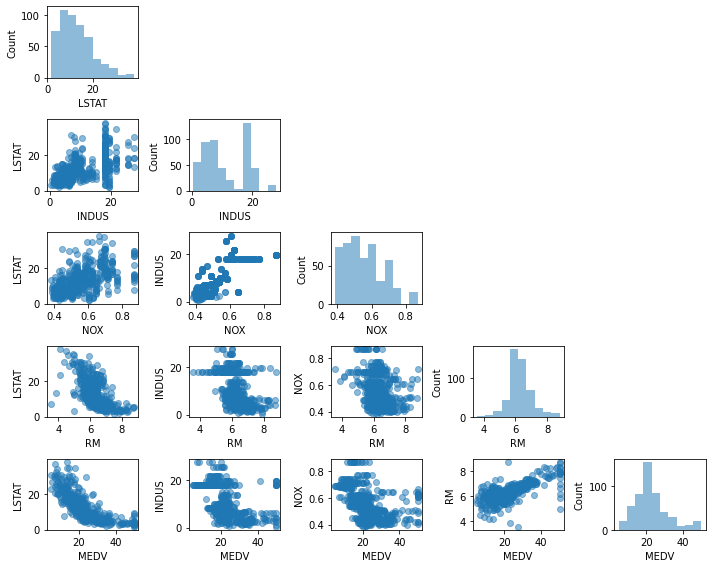

In [7]:
cols = ["LSTAT", "INDUS", "NOX", "RM", "MEDV"]
scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

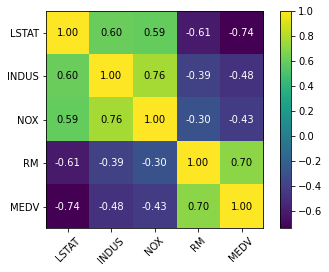

In [8]:
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

## 10.3

In [10]:
class LinearRegressionGD(object):
    def __init__(self,
                 eta=0.001,  # 学習率
                 n_iter=20,  # 訓練回数
                 ):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

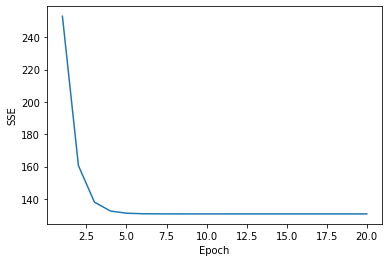

In [11]:
X = df[["RM"]].values
y = df["MEDV"].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel("SSE")
plt.xlabel("Epoch")
plt.show()

In [12]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
    plt.plot(X, model.predict(X), color="black", lw=2)
    return None

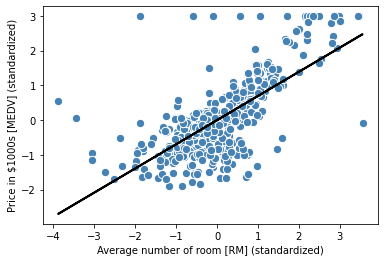

Price in $1000s:  10.840
Slope:  0.695
Intercept: -0.000


In [19]:
lin_regplot(X_std, y_std, lr)
plt.xlabel("Average number of room [RM] (standardized)")
plt.ylabel("Price in $1000s [MEDV] (standardized)")
plt.show()

num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print(f"Price in $1000s: {sc_y.inverse_transform(price_std)[0]: .3f}")

print(f"Slope: {lr.w_[1]: .3f}")
print(f"Intercept: {lr.w_[0]: .3f}")

Slope:  9.102
Intercept: -34.671


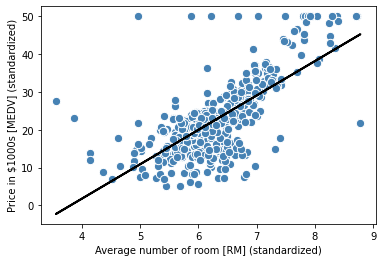

In [21]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f"Slope: {slr.coef_[0]: .3f}")
print(f"Intercept: {slr.intercept_: .3f}")

lin_regplot(X, y, slr)
plt.xlabel("Average number of room [RM] (standardized)")
plt.ylabel("Price in $1000s [MEDV] (standardized)")
plt.show()

## 10.4

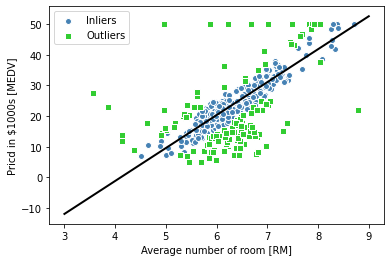

Slope:  10.735
Intercept: -44.089


In [24]:
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, loss="absolute_loss", residual_threshold=5.0, random_state=0)
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c="steelblue", edgecolor="white", marker="o", label="Inliers")
plt.scatter(X[outlier_mask], y[outlier_mask], c="limegreen", edgecolor="white", marker="s", label="Outliers")
plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Average number of room [RM]")
plt.ylabel("Pricd in $1000s [MEDV]")
plt.legend(loc="upper left")
plt.show()

print(f"Slope: {ransac.estimator_.coef_[0]: .3f}")
print(f"Intercept: {ransac.estimator_.intercept_: .3f}")

## 10.5

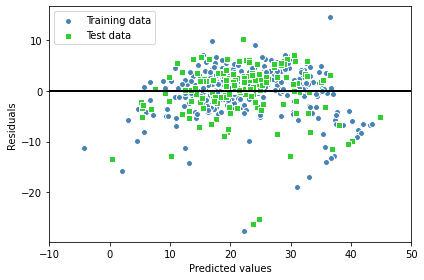

MSE train:  19.958, test:  27.196
R^2 train:  0.765, test:  0.673


In [27]:
X = df.iloc[:, :-1].values
y = df["MEDV"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

plt.scatter(y_train_pred, y_train_pred - y_train, c="steelblue", marker="o", edgecolor="white", label="Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c="limegreen", marker="s", edgecolor="white", label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

print(f"MSE train: {mean_squared_error(y_train, y_train_pred): .3f}, test: {mean_squared_error(y_test, y_test_pred): .3f}")

print(f"R^2 train: {r2_score(y_train, y_train_pred): .3f}, test: {r2_score(y_test, y_test_pred): .3f}")

## 10.6

In [ ]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

## 10.7

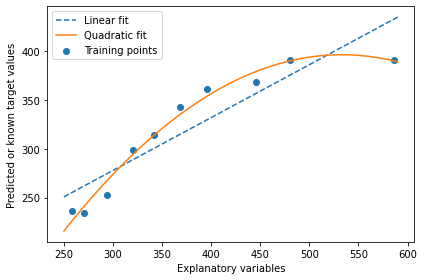

Training MSE linear:  569.780, quadratic:  61.330
Training R^2 linear:  0.832, quad:  0.982


In [30]:
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label="Training points")
plt.plot(X_fit, y_lin_fit, label="Linear fit", linestyle="--")
plt.plot(X_fit, y_quad_fit, label="Quadratic fit")
plt.xlabel("Explanatory variables")
plt.ylabel("Predicted or known target values")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print(f"Training MSE linear: {mean_squared_error(y, y_lin_pred): .3f}, quadratic: {mean_squared_error(y, y_quad_pred): .3f}")
print(f"Training R^2 linear: {r2_score(y, y_lin_pred): .3f}, quad: {r2_score(y, y_quad_pred): .3f}")

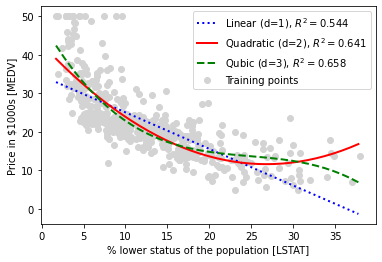

In [35]:
X = df[["LSTAT"]].values
y = df["MEDV"].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label="Training points", color="lightgray")
plt.plot(X_fit, y_lin_fit, label=f"Linear (d=1), $R^2={linear_r2:.2f}$", color="blue", lw=2, linestyle=":")
plt.plot(X_fit, y_quad_fit, label=f"Quadratic (d=2), $R^2={quadratic_r2:.2f}$", color="red", lw=2, linestyle="-")
plt.plot(X_fit, y_cubic_fit, label=f"Qubic (d=3), $R^2={cubic_r2:.2f}$", color="green", lw=2, linestyle="--")
plt.xlabel("% lower status of the population [LSTAT]")
plt.ylabel("Price in $1000s [MEDV]")
plt.legend(loc="upper right")
plt.show()

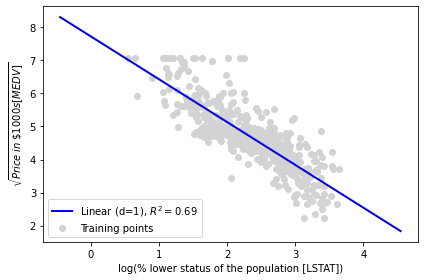

In [36]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label="Training points", color="lightgray")
plt.plot(X_fit, y_lin_fit, label=f"Linear (d=1), $R^2={linear_r2:.2f}$", color="blue", lw=2)
plt.xlabel("log(% lower status of the population [LSTAT])")
plt.ylabel("$\sqrt{Price \; in \; \$1000s [MEDV]}$")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

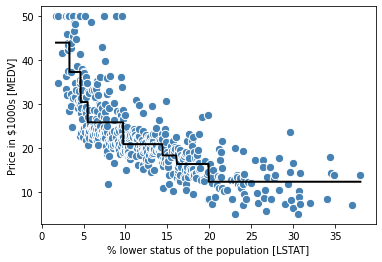

In [42]:
X = df[["LSTAT"]].values
y = df["MEDV"].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("% lower status of the population [LSTAT]")
plt.ylabel("Price in $1000s [MEDV]")
plt.show()

MSE train:  1.644, test:  11.085
R^2 train:  0.979, test:  0.877


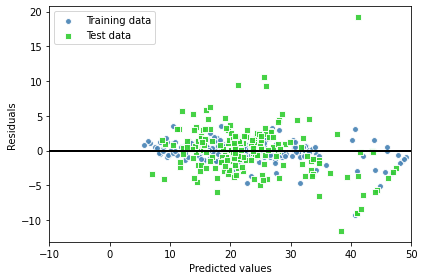

In [44]:
X = df.iloc[:, :-1].values
y = df["MEDV"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
forest = RandomForestRegressor(n_estimators=1000, criterion="mse", random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print(f"MSE train: {mean_squared_error(y_train, y_train_pred): .3f}, test: {mean_squared_error(y_test, y_test_pred): .3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred): .3f}, test: {r2_score(y_test, y_test_pred): .3f}")

plt.scatter(y_train_pred, y_train_pred - y_train, c="steelblue", marker="o", edgecolor="white", s=35, alpha=0.9, label="Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c="limegreen", marker="s", edgecolor="white", s=35, alpha=0.9, label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()
